In [3]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], "GPU")
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


# Data Preprocessing

In [5]:
# Image Parameters
IMG_SIZE = 224
BATCH_SIZE = 32

In [6]:
dataset_path = "dataset/input"
output_dir = "dataset/split_dataset"
os.makedirs(output_dir, exist_ok=True)

all_images = []
all_labels = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            all_images.append(img_path)
            all_labels.append(class_name)

df = pd.DataFrame({"image": all_images, "label": all_labels})

# Split the dataset into training (60%), validation (20%), and test sets (20%)
train_df, temp_df = train_test_split(
    df, test_size=0.4, stratify=df["label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
)

test_labels = test_df["label"].values
unique_labels = set(test_labels)

print(f"Total images: {len(df)}")
print(f"Unique Labels: {unique_labels})")


print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Total images: 15000
Unique Labels: {'squamous_cell_carcinoma', 'benign', 'adenocarcinoma'})
Training set size: 9000
Validation set size: 3000
Test set size: 3000


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

Found 9000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


In [28]:
# Get the mapping of class indices to labels
class_indices = train_generator.class_indices

# Reverse the mapping to get index-to-label mapping
index_to_label = {v: k for k, v in class_indices.items()}

# Print the mapping
print("Index to Label Mapping:")
for index, label in index_to_label.items():
    print(f"{index}: {label}")

Index to Label Mapping:
0: adenocarcinoma
1: benign
2: squamous_cell_carcinoma


Image shape: (32, 224, 224, 3)


<Figure size 640x480 with 0 Axes>

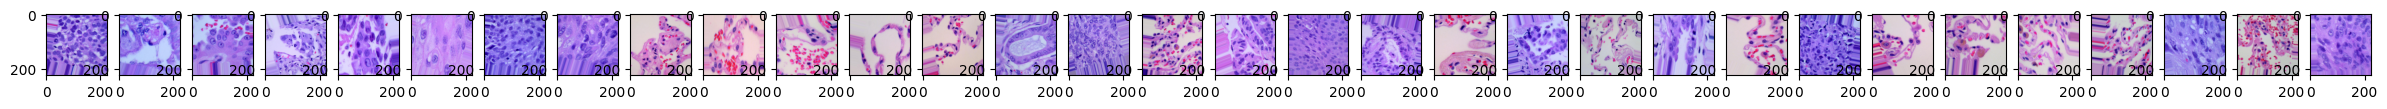

In [8]:
images, labels = train_generator[0]
print(f"Image shape: {images.shape}")

plt.figure()

# subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4))


for i in range(images.shape[0]):
    axarr[i].imshow(images[i])

# Utility Functions

In [9]:
def plot_accuracy_history(history):
    """
    Plot the training and validation accuracy history.
    This function takes the training history object and plots the accuracy
    for both training and validation datasets over the epochs.

    Args:
        history: The training history object returned by the fit method.
    """
    # Extract accuracty values
    train_loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(train_loss) + 1)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(
        epochs, train_loss, "bo-", label="Training Accuracy"
    )  # 'bo-' = blue circles with a solid line
    plt.plot(
        epochs, val_loss, "r^-", label="Validation Accuracy"
    )  # 'r^-' = red triangles with a solid line
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs. Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

In [10]:
def plot_loss_history(history):
    """
    Plot the training and validation loss history.
    This function takes the training history object returned by the fit method
    and plots the training and validation loss over epochs.
    The x-axis represents the epochs, and the y-axis represents the loss values.
    The training loss is plotted with blue circles and a solid line, while the validation loss
    is plotted with red triangles and a solid line.

    Args:
        history: The training history object returned by the fit method.
    """
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(train_loss) + 1)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(
        epochs, train_loss, "bo-", label="Training Loss"
    )  # 'bo-' = blue circles with a solid line
    plt.plot(
        epochs, val_loss, "r^-", label="Validation Loss"
    )  # 'r^-' = red triangles with a solid line
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs. Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

In [11]:
def train_model(model, epochs, train_generator, val_generator):
    """
    Train the model using the provided training and validation generators.
    This function takes a Keras model, the number of epochs, and the training and validation data generators.
    """
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
    )

    return history

In [12]:
def evaluate_model(model):
    loss, accuracy, precision, recall = model.evaluate(test_generator, steps=25)
    print("\ntest acc :\n", accuracy)

    # Evaluate Model
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    y_val = test_generator.classes
    print(classification_report(y_val, y_pred))

    #  Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(
        confusion_matrix(y_val, y_pred),
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=unique_labels,
        yticklabels=unique_labels,
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Initial Model

In [13]:
# Model Parameters
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
FILTER1_SIZE = 32
FILTER2_SIZE = 64
FILTER_SHAPE = (3, 3)
POOL_SHAPE = (2, 2)
FULLY_CONNECT_NUM = 128
NUM_CLASSES = 3
METRICS = ["accuracy", Precision(name="precision"), Recall(name="recall")]
LEARNING_RATE = 2e-5
# Define the number of epochs
EPOCHS = 20

In [14]:
# Model architecture implementation
model = Sequential()
model.add(
    Conv2D(FILTER1_SIZE, FILTER_SHAPE, activation="relu", input_shape=INPUT_SHAPE)
)
model.add(MaxPooling2D(POOL_SHAPE))
model.add(Conv2D(FILTER2_SIZE, FILTER_SHAPE, activation="relu"))
model.add(MaxPooling2D(POOL_SHAPE))
model.add(Flatten())
model.add(Dense(FULLY_CONNECT_NUM, activation="relu"))
model.add(Dense(NUM_CLASSES, activation="softmax"))

model.summary()

model.compile(
    loss="categorical_crossentropy",
    optimizer=RMSprop(learning_rate=LEARNING_RATE),
    metrics=METRICS,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [15]:
history = train_model(model, EPOCHS, train_generator, val_generator)

Epoch 1/20
282/282 [==============================] - 86s 290ms/step - loss: 0.5438 - accuracy: 0.7200 - precision: 0.7499 - recall: 0.6776 - val_loss: 0.4502 - val_accuracy: 0.7747 - val_precision: 0.7810 - val_recall: 0.7610
Epoch 2/20
282/282 [==============================] - 73s 259ms/step - loss: 0.4312 - accuracy: 0.7910 - precision: 0.7956 - recall: 0.7849 - val_loss: 0.4430 - val_accuracy: 0.7643 - val_precision: 0.7692 - val_recall: 0.7600
Epoch 3/20
282/282 [==============================] - 82s 289ms/step - loss: 0.3736 - accuracy: 0.8307 - precision: 0.8327 - recall: 0.8258 - val_loss: 0.3531 - val_accuracy: 0.8353 - val_precision: 0.8359 - val_recall: 0.8320
Epoch 4/20
282/282 [==============================] - 81s 287ms/step - loss: 0.3405 - accuracy: 0.8494 - precision: 0.8504 - recall: 0.8464 - val_loss: 0.3279 - val_accuracy: 0.8470 - val_precision: 0.8487 - val_recall: 0.8453
Epoch 5/20
282/282 [==============================] - 74s 260ms/step - loss: 0.3118 - accura

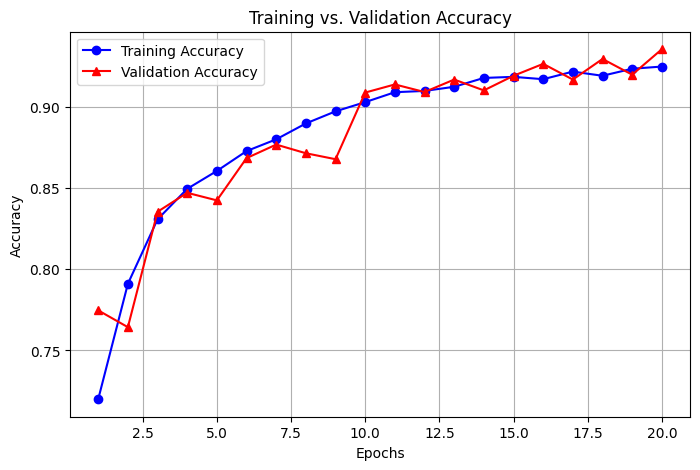

In [16]:
plot_accuracy_history(history)

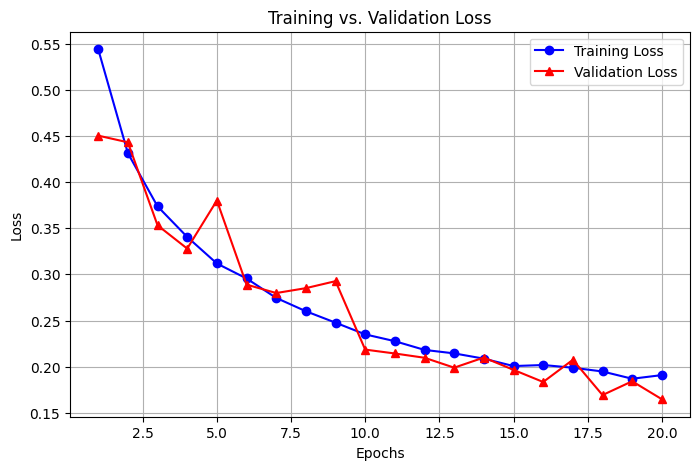

In [17]:
plot_loss_history(history)

25/25 [==============================] - 3s 109ms/step - loss: 0.1506 - accuracy: 0.9400 - precision: 0.9412 - recall: 0.9400

test acc :
 0.9399999976158142
94/94 [==============================] - 10s 104ms/step
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1000
           1       1.00      0.98      0.99      1000
           2       0.93      0.90      0.92      1000

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



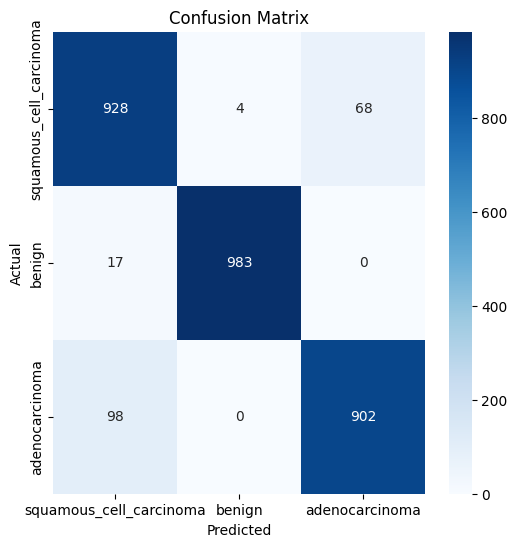

In [18]:
evaluate_model(model)
# Save the model
model.save("model_v1.keras")

## Upgraded Model

In [19]:
# Model Parameters
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
FILTER1_SIZE = 64
FILTER2_SIZE = 32
FILTER_SHAPE = (3, 3)
POOL_SHAPE = (2, 2)
FULLY_CONNECT_NUM_1 = 256
FULLY_CONNECT_NUM_2 = 128
NUM_CLASSES = 3
METRICS = ["accuracy", Precision(name="precision"), Recall(name="recall")]
LEARNING_RATE = 1e-3
# Define the number of epochs
EPOCHS = 20

In [20]:
# Model definition
model = Sequential()

# Layer 1
model.add(
    Conv2D(FILTER1_SIZE, FILTER_SHAPE, activation="relu", input_shape=INPUT_SHAPE)
)
model.add(MaxPooling2D(pool_size=POOL_SHAPE))

# Layer 2
model.add(Conv2D(FILTER2_SIZE, FILTER_SHAPE, activation="relu"))
model.add(MaxPooling2D(pool_size=POOL_SHAPE))

# Layer 3
model.add(Conv2D(FILTER2_SIZE, FILTER_SHAPE, activation="relu"))
model.add(Dropout(0.4))

# Layer 4 - Flatten
model.add(Flatten())

# Layer 5 - Dense layers
model.add(Dense(FULLY_CONNECT_NUM_1, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(FULLY_CONNECT_NUM_2, activation="relu"))

# Output layer
model.add(Dense(NUM_CLASSES, activation="softmax"))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=METRICS,
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 52, 52, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 52, 52, 32)       

In [21]:
history = train_model(model, EPOCHS, train_generator, val_generator)

Epoch 1/20
282/282 [==============================] - 76s 266ms/step - loss: 0.4361 - accuracy: 0.8220 - precision: 0.8315 - recall: 0.8082 - val_loss: 0.3558 - val_accuracy: 0.8470 - val_precision: 0.8469 - val_recall: 0.8467
Epoch 2/20
282/282 [==============================] - 72s 256ms/step - loss: 0.3401 - accuracy: 0.8591 - precision: 0.8606 - recall: 0.8563 - val_loss: 0.3300 - val_accuracy: 0.8707 - val_precision: 0.8716 - val_recall: 0.8687
Epoch 3/20
282/282 [==============================] - 79s 279ms/step - loss: 0.2880 - accuracy: 0.8850 - precision: 0.8856 - recall: 0.8847 - val_loss: 0.2091 - val_accuracy: 0.9107 - val_precision: 0.9107 - val_recall: 0.9107
Epoch 4/20
282/282 [==============================] - 96s 321ms/step - loss: 0.2733 - accuracy: 0.8907 - precision: 0.8916 - recall: 0.8899 - val_loss: 0.2141 - val_accuracy: 0.9097 - val_precision: 0.9102 - val_recall: 0.9090
Epoch 5/20
282/282 [==============================] - 75s 267ms/step - loss: 0.2570 - accura

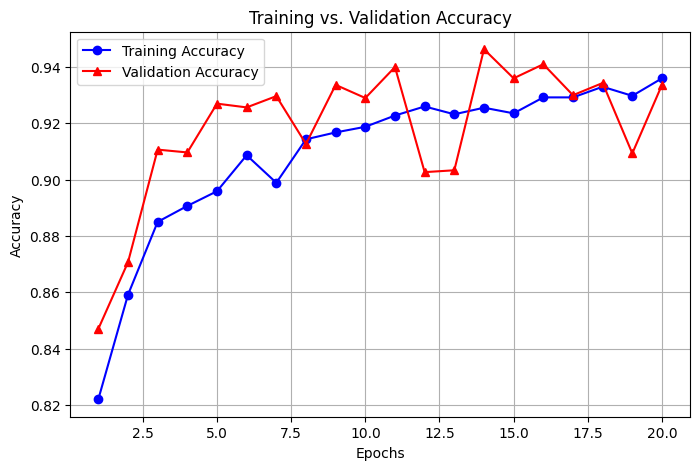

In [22]:
plot_accuracy_history(history)

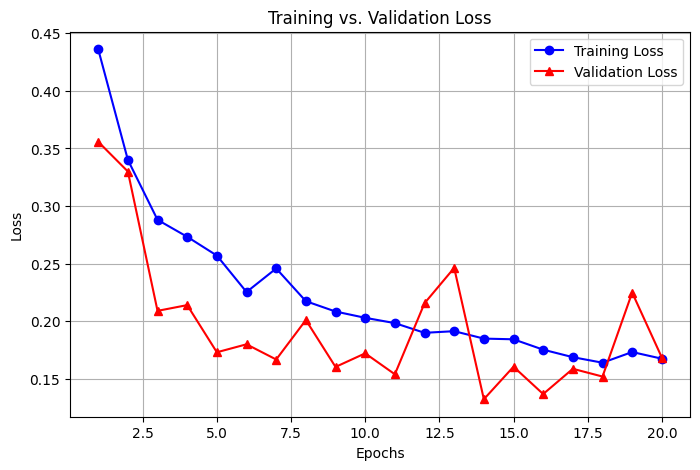

In [23]:
plot_loss_history(history)

25/25 [==============================] - 3s 117ms/step - loss: 0.1594 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350

test acc :
 0.9350000023841858
94/94 [==============================] - 16s 166ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1000
           1       1.00      0.97      0.98      1000
           2       0.91      0.94      0.92      1000

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



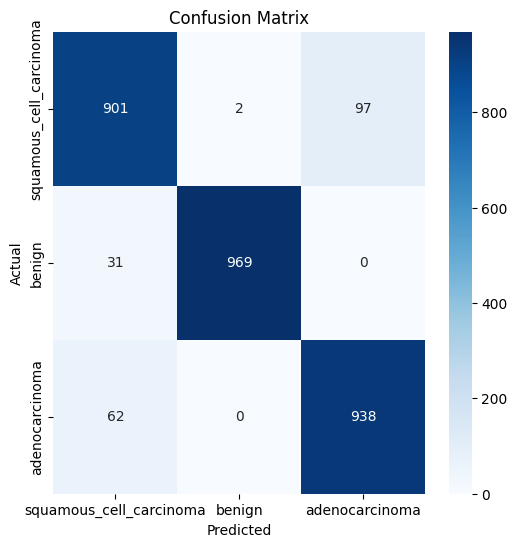

In [24]:
evaluate_model(model)
# Save the model
model.save("model_v2.keras")

# Final Model

In [25]:
# Model Parameters
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
FILTER1_SIZE = 64
FILTER2_SIZE = 32
FILTER_SHAPE = (3, 3)
POOL_SHAPE = (2, 2)
FULLY_CONNECT_NUM_1 = 256
FULLY_CONNECT_NUM_2 = 128
NUM_CLASSES = 3
METRICS = ["accuracy", Precision(name="precision"), Recall(name="recall")]
LEARNING_RATE = 1e-3
# Define the number of epochs
EPOCHS = 50

In [26]:
# Model definition
model = Sequential()

# Layer 1
model.add(
    Conv2D(FILTER1_SIZE, FILTER_SHAPE, activation="relu", input_shape=INPUT_SHAPE)
)
model.add(MaxPooling2D(pool_size=POOL_SHAPE))

# Layer 2
model.add(Conv2D(FILTER2_SIZE, FILTER_SHAPE, activation="relu"))
model.add(MaxPooling2D(pool_size=POOL_SHAPE))

# Layer 3
model.add(Conv2D(FILTER2_SIZE, FILTER_SHAPE, activation="relu"))
model.add(Dropout(0.4))

# Layer 4 - Flatten
model.add(Flatten())

# Layer 5 - Dense layers
model.add(Dense(FULLY_CONNECT_NUM_1, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(FULLY_CONNECT_NUM_2, activation="relu"))

# Output layer
model.add(Dense(NUM_CLASSES, activation="softmax"))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=METRICS,
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 52, 52, 32)        9248      
                                                                 
 dropout_2 (Dropout)         (None, 52, 52, 32)       

In [27]:
history = train_model(model, EPOCHS, train_generator, val_generator)

Epoch 1/50
282/282 [==============================] - 107s 378ms/step - loss: 0.4851 - accuracy: 0.7794 - precision: 0.7981 - recall: 0.7628 - val_loss: 0.4103 - val_accuracy: 0.8003 - val_precision: 0.8025 - val_recall: 0.7980
Epoch 2/50
282/282 [==============================] - 104s 368ms/step - loss: 0.3193 - accuracy: 0.8736 - precision: 0.8742 - recall: 0.8718 - val_loss: 0.2790 - val_accuracy: 0.8850 - val_precision: 0.8856 - val_recall: 0.8850
Epoch 3/50
  7/282 [..............................] - ETA: 1:15 - loss: 0.2499 - accuracy: 0.9018 - precision: 0.9058 - recall: 0.9018

KeyboardInterrupt: 

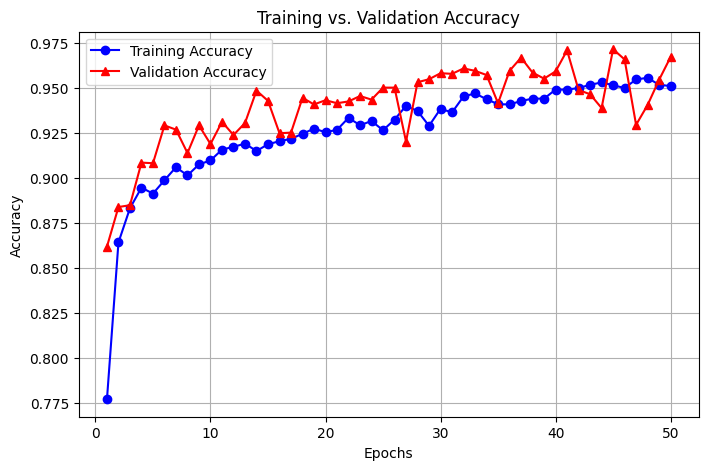

In [ ]:
plot_accuracy_history(history)

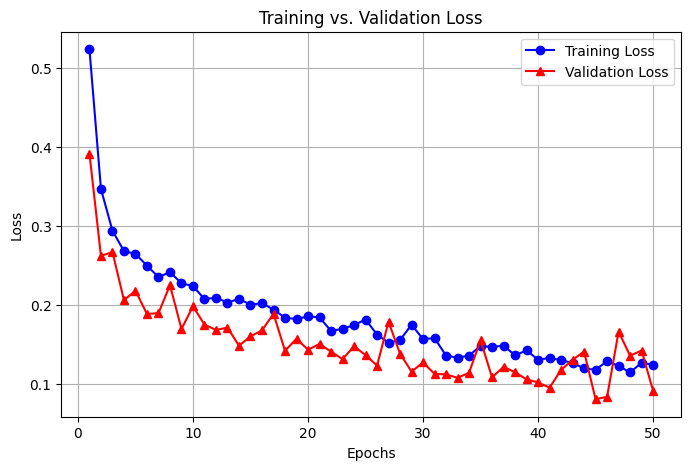

In [ ]:
plot_loss_history(history)

94/94 [==============================] - 8s 90ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1000
           1       1.00      1.00      1.00      1000
           2       0.95      0.97      0.96      1000

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



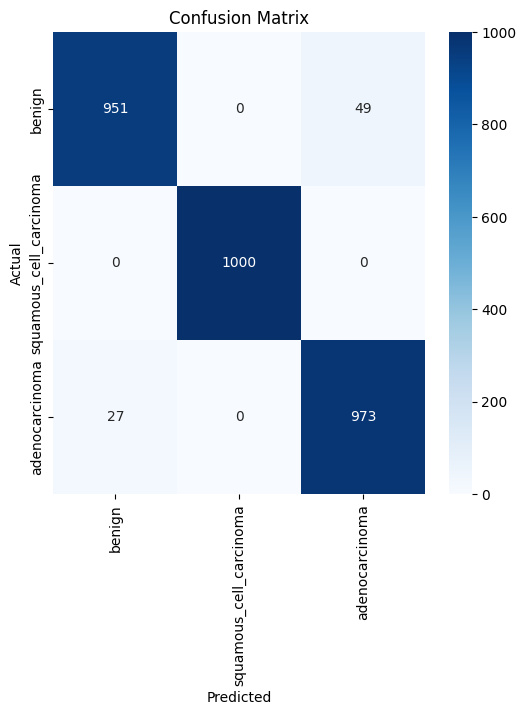

In [ ]:
evaluate_model(model)
# Save the model
model.save("model_v3.keras")